# FlatΛCDM Cosmological Parameter Estimation with DESI + CMB Data

This notebook derives the cosmological parameters for a **FlatΛCDM** model by minimizing the joint $χ^2$ function using both DESI BAO and CMB data.

- **Model:** FlatΛCDM (with $H_0$, $\Omega_m$ as free parameters; $r_d$ is derived from CMB parameters)
- **Data:** DESI BAO measurements + CMB constraints ($\theta_*$, $w_b$, $w_{bc}$, with covariance)
- **Method:**
  - Uses the [`CosmologicalDistances`](../../pyACC/cosmology/distances.py) class from the `pyACC` library
  - Uses the [`FlatLambdaCDM`](../../pyACC/cosmology/cosmology.py) class from the `pyACC` library
  - Minimization performed with `scipy.optimize.minimize`

> **Note:** With DESI data alone, only the product $H_0 \cdot r_d$ can be robustly constrained, not $H_0$ and $r_d$ separately. By including CMB constraints, $r_d$ is determined from $w_b$ and $w_{bc}$, allowing $H_0$ to be fit directly.

In [ ]:
import sys
sys.path.append('/home/giorgio/Documents/Scuola/Università/Università_di_Genova/IV_ANNO/II_Semestre/Astrofisica Computazionale/ESAME/ToloAstroCosmoLib')

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u 
import pandas as pd

from pyACC.cosmology.cosmology import FlatLambdaCDM
from pyACC.cosmology.distances import CosmologicalDistances

# Example: set CMB means and covariance matrix manually
theta_star_mean = 0.010141   #Angualr scale of the sound horizon at recombination
w_b_mean = 0.02223           #Physical baryon density
w_bc_mean = 0.14208          #Physical cold dark matter density

Neff = 3.046                 #Effective number of relativistic neutrinos (I'm effectivly neglecting the neutrinos mass)


# Hubble constant in units of 100 km/s/Mpc (thus dimensionless)
def h(H0):
    return H0 / 100  

# Energy baryon ratio
def Omega_b(w_b_mean, H0):
    return w_b_mean / (h(H0)**2) 

# Energy cold dark matter ratio
def Omega_bc(w_bc_mean, H0):
    return w_bc_mean / (h(H0)**2)


cmb_means = np.array([theta_star_mean, w_b_mean, w_bc_mean])

# Example covariance matrix (replace with actual values)
cmb_cov = np.array([
    [0.006621e-9, 0.12444e-9, -1.1929e-9],
    [0.12444e-9, 21.344e-9, -94.001e-9],
    [-1.1929e-9, -94.001e-9, 1488.4e-9]
])
cmb_cov_inv = np.linalg.inv(cmb_cov)

In [14]:
# Load DESI data from data.csv
file_data = "data.csv"
data = pd.read_csv(file_data)
data = data.astype(float)

z = data["z_eff"].values

D_M_over_r_d = data["D_M / r_d"].values
D_M_over_r_d_err = data["D_M / r_d_err"].values

D_V_obs = data["D_V / r_d"].values
D_V_err = data["D_V / r_d_err"].values


## Error propagation for $r_d$ using the CMB means and covariance

I propagate the uncertainties on $w_b$ and $w_{bc}$ to $r_d$ using the derivative error propagation formula for a function of correlated variables.

In [15]:
#from DESI paper (2):
def r_d(w_b, w_bc, Neff=3.046):
    return 147.05 * ((w_b/0.02236)**(-0.13)) * ((w_bc/0.1432)**(-0.23)) * ((Neff/3.046)**(-0.1))

# I compute r_b at the mean values
r_d_val = r_d(w_b_mean, w_bc_mean, Neff)

# Partial derivatives 
drb_dw_b = r_d_val * -0.13 / w_b_mean 
drb_dw_bc = r_d_val * -0.23 / w_bc_mean

# I define the gradient vector (Neff is fixed thus I only have two correlated parameters)
grad = np.array([drb_dw_b, drb_dw_bc])

# I Extract the relevant 2x2 covariance South-East minor for (w_b, w_bc)
cov_wb_wbc = cmb_cov[1:3, 1:3]

#I Propagate the error (for my future self: @ is RxC product)
var_r_b = grad @ cov_wb_wbc @ grad.T
sigma_r_b = np.sqrt(var_r_b)
print(f"r_d = {r_d_val:.3f} ± {sigma_r_b:.3f} Mpc")

r_d = 147.428 ± 0.249 Mpc


## Joint Chi-square Function for DESI + CMB

This function combines the DESI BAO data and the CMB constraints (means and covariance) to find the best-fit FlatLambdaCDM parameters.

In [16]:
from scipy.linalg import inv

def model_cmb_params(H0):
    # theta_star is fixed, w_b and w_bc are computed from H0
    return np.array([theta_star_mean, w_b_mean, w_bc_mean])

def joint_chi2(params):
    H0, Omega_m = params[:2]
    Omega_radiation = 0.0  #for completeness
    model = FlatLambdaCDM(H0, Omega_m, Omega_radiation)

    # DESI chi2: compare D_V/r_d at each z
    D_V_model = np.array([CosmologicalDistances(model.H).volume_distance(z_i) for z_i in z])
    chi2_desi = np.sum(((D_V_obs - D_V_model / r_d_val) / D_V_err) ** 2)

    # CMB chi2: compare model CMB params to means using covariance
    cmb_model = model_cmb_params(H0)
    delta = cmb_model - cmb_means
    chi2_cmb = delta @ cmb_cov_inv @ delta

    return chi2_desi + chi2_cmb

## Minimize the joint chi-square and plot the best-fit model

In [17]:
from scipy.optimize import minimize, approx_fprime

# Initial guess for H0 and Omega_m
initial_guess = [79.0, 0.03]

# Minimize the joint chi-square
result = minimize(joint_chi2, initial_guess, bounds=[(60, 80), (0, 1)])

if result.success:
    best_H0, best_Omega_m = result.x
    print(f"Minimum chi2/dof: {result.fun/2:.2f}")

    # Estimate errors using the inverse Hessian
    def hessian(func, x0, epsilon=1e-5):
        n = len(x0)
        hess = np.zeros((n, n))
        for i in range(n):
            x1 = np.array(x0, dtype=float)
            x1[i] += epsilon
            grad1 = approx_fprime(x1, func, epsilon)
            x2 = np.array(x0, dtype=float)
            x2[i] -= epsilon
            grad2 = approx_fprime(x2, func, epsilon)
            hess[:, i] = (grad1 - grad2) / (2 * epsilon)
        return hess

    hess = hessian(joint_chi2, result.x)
    cov = np.linalg.inv(hess)
    errors = np.sqrt(np.diag(cov))
    print(f"H0 = {best_H0:.3f} ± {errors[0]:.3f}")
    print(f"Omega_m = {best_Omega_m:.4f} ± {errors[1]:.4f}")
else:
    print("Minimization failed:", result.message)

Minimum chi2/dof: 2.32
H0 = 68.851 ± 0.454
Omega_m = 0.2980 ± 0.0087


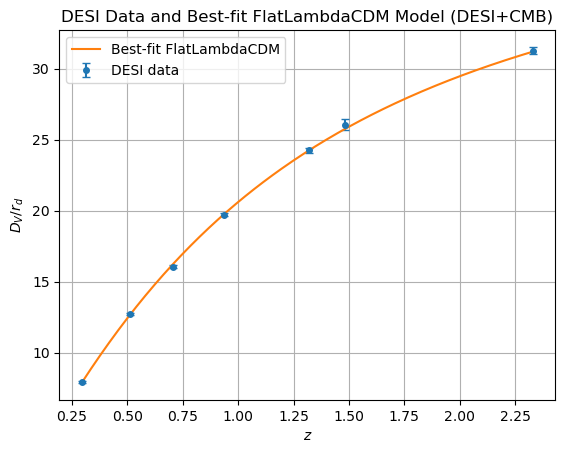

In [18]:
# Plot DESI data and best-fit model
z_plot = np.linspace(np.min(z), np.max(z), 200)
model_best = FlatLambdaCDM(best_H0, best_Omega_m)
distances_best = CosmologicalDistances(model_best.H)
D_V_model_plot = np.array([distances_best.volume_distance(z_i) for z_i in z_plot]) / r_d_val

plt.errorbar(z, D_V_obs, yerr=D_V_err, fmt='o', markersize=4, label='DESI data', capsize=3)
plt.plot(z_plot, D_V_model_plot, label='Best-fit FlatLambdaCDM', color='C1')
plt.xlabel(r"$z$")
plt.ylabel(r"$D_V / r_d$")
plt.title("DESI Data and Best-fit FlatLambdaCDM Model (DESI+CMB)")
plt.legend()
plt.grid(True)
plt.show()

## Comparison with Literature: arXiv:2411.12020v1

<div style="background: #f6f8fa; border-left: 4px solid #0366d6; padding: 1em 1.5em; margin-bottom: 1em;">
<b>Paper Reference:</b> <a href="https://arxiv.org/abs/2411.12020v1" target="_blank">arXiv:2411.12020v1</a>  
<b>Table V, Flat ΛCDM, DESI+CMB fit</b>
</div>

| Flat ΛCDM         | My $χ^2$ minimization         |My MCMC sample    | Paper|
|-------------------|-------------------------------|-------------------|----------------------------|
| $H_0$   | $68.851 \pm 0.454 \,\text{km/s/Mpc}$   |$68.82 \pm 0.64 \,\text{km/s/Mpc}$| $68.17 \pm 0.33 \,\text{km/s/Mpc}$              |
| $\Omega_m$        | $0.2980 \pm 0.0943$           | $00.299 \pm 0.012$       | $0.3034 \pm 0.0037$|